# Second assignment: Analyse your "realistic" graph

## Load Dataset

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import collections, itertools
import networkx as nx

In [4]:
G = nx.Graph()
edges = nx.read_edgelist('../datasets/dataset.txt')
G.add_edges_from(edges.edges())
posTotal = nx.spring_layout(G)

/Users/danilo/.conda/envs/ga/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


Number of nodes: 5242
Number of edges: 14496


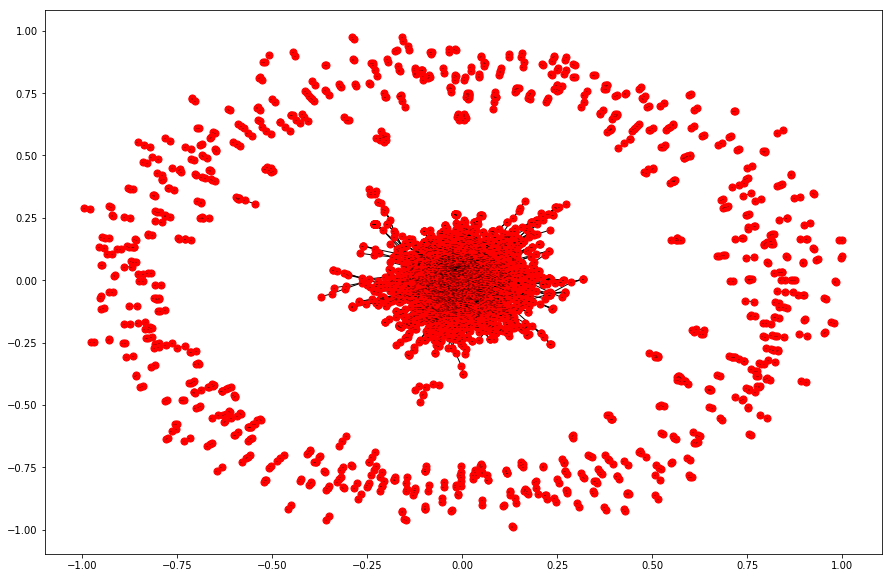

In [5]:
plt.figure(figsize=(15,10))
nx.draw_networkx(G,posTotal, font_size=0, node_size=50)

#Print node numbers 
print("Number of nodes:",G.number_of_nodes())
#Print edges number G.number_of_edges()
print("Number of edges:",G.number_of_edges())

### Dataset stats (from https://snap.stanford.edu/data/ca-GrQc.html)
<img src="images/dataset.png">

## Node level measurements

In [74]:
#Utils class

class statistics:
    
    def __init__(self, d, measure):
        self.measure = measure
        self.orderedList = sorted(list(d.items()), key=lambda pair: pair[1])
        self.orderedKeys = sorted(list(d.keys()))
        self.orderedValues = sorted(list(d.values()))
    
    def average(self):    
        return np.mean(self.orderedValues)

    def variance(self):
        return np.var(self.orderedValues)

    def maximum(self):
        return self.orderedList[-1]

    def minimum(self):
        return self.orderedList[0]

    def median(self):
        return self.orderedList[len(self.orderedList)//2]
    
    def print_info(self):
        print("{} distribution:\n\taverage: {}\n\tvariance: {}\n\tmaximum: {}\n\tminimum: {}\n\tmedian: {}\n"
              .format(self.measure,self.average(),self.variance(),
                      self.maximum(),self.minimum(),self.median()))
    
    def barplot(self):
        keys, cnt = zip(*collections.Counter(self.orderedValues).items())

        plt.figure(figsize=(15,10))
        plt.bar(keys, cnt, width=0.80, color='b')
        plt.title(self.measure+" barplot")
        plt.ylabel("Count")
        plt.xlabel(self.measure)
        plt.xticks(deg, rotation=90)
        plt.tight_layout()
    
    def histogram(self, bins=10):
        plt.figure(figsize=(15,8))
        counts,bins,_ = plt.hist(self.orderedValues, bins=bins)
                                  
        bin_centers = 0.5 * np.diff(bins) + bins[:-1]
        for count, x in zip(counts, bin_centers):
            # Label the raw counts
            plt.annotate(str(count), xy=(x, 0), xycoords=('data', 'axes fraction'),
                         xytext=(0, -20), textcoords='offset points', va='top', ha='center')
            # Label the percentages
            percent = '%0.0f%%' % (100 * float(count) / counts.sum())
            plt.annotate(percent, xy=(x, 0), xycoords=('data', 'axes fraction'),
                         xytext=(0, -35), textcoords='offset points', va='top', ha='center')
        
        plt.title(self.measure+" histogram")
        plt.ylabel("Count")
        plt.xticks(bins)
        plt.show()

### Degree distribution

Degree distribution:
	average: 5.530713468141931
	variance: 62.70117419527453
	maximum: ('21012', 81)
	minimum: ('24372', 1)
	median: ('19454', 3)



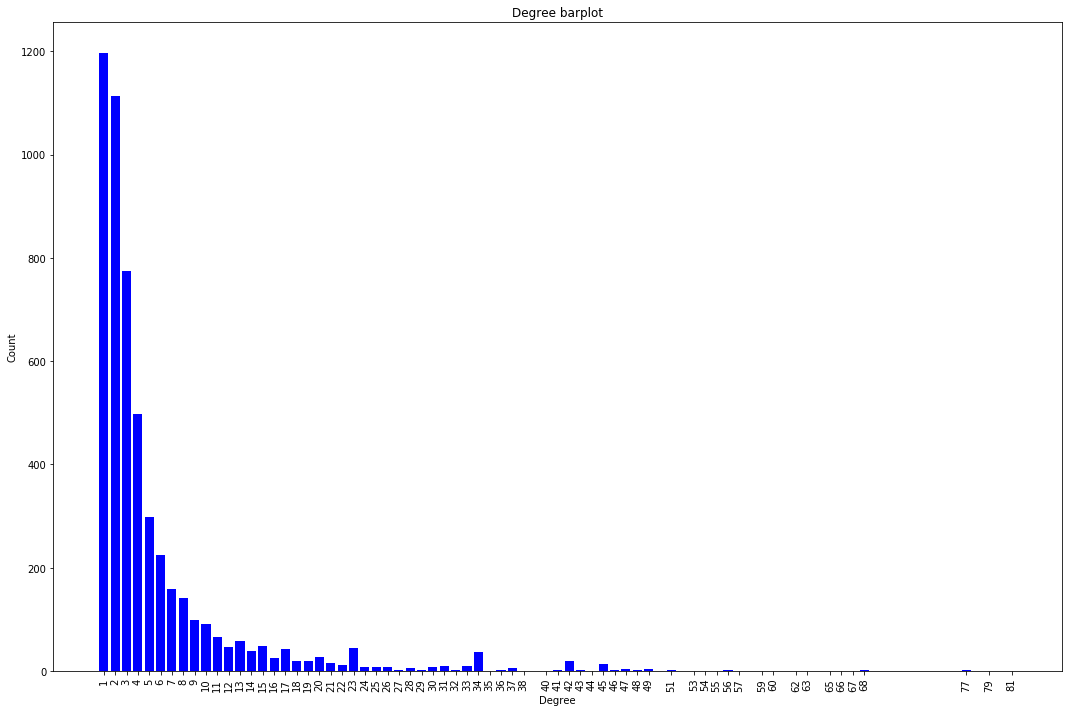

In [75]:
degree_stat = statistics(dict(G.degree),"Degree")
degree_stat.print_info()
degree_stat.barplot()

### Betweenness

In [63]:
btwc = nx.betweenness_centrality(G)

Betweenness distribution:
	average: 0.0006062707858585127
	variance: 3.8989784331005185e-06
	maximum: ('13801', 0.03702715043389754)
	minimum: ('5233', 0.0)
	median: ('21594', 0.0)



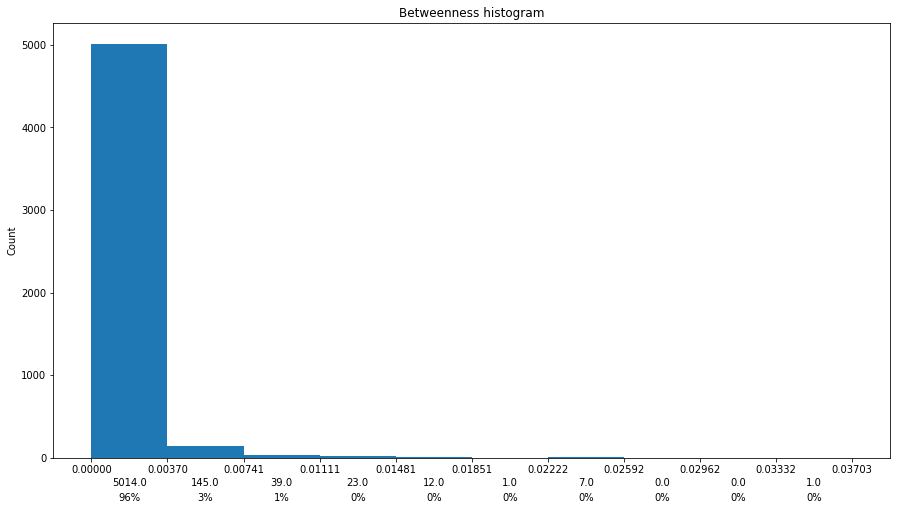

In [76]:
between_stat = statistics(btwc, "Betweenness")
between_stat.print_info()
between_stat.histogram()

### Closeness

In [65]:
clsn = nx.closeness_centrality(G)

Closeness distribution:
	average: 0.10630130466094839
	variance: 0.0032024611226696186
	maximum: ('13801', 0.19428463503141283)
	minimum: ('12295', 0.0)
	median: ('2607', 0.12792258161466954)



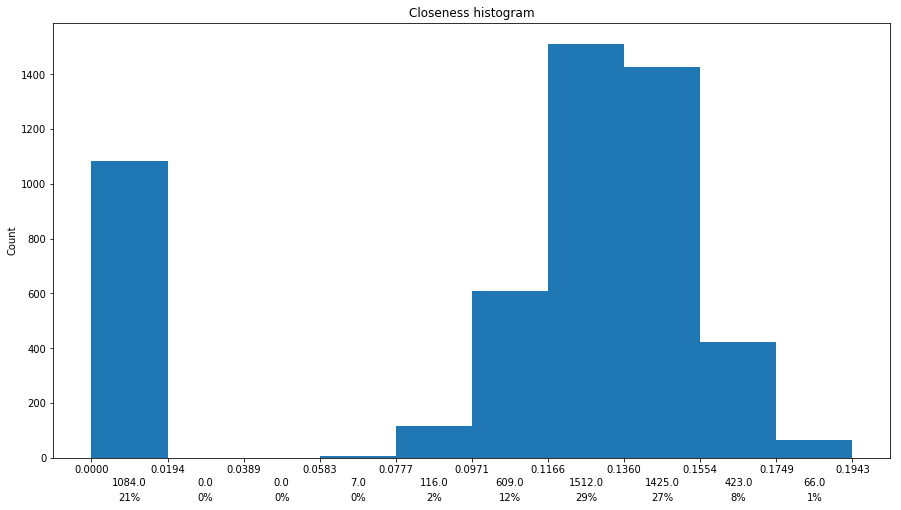

In [77]:
close_stat = statistics(clsn, "Closeness")
close_stat.print_info()
close_stat.histogram()

### Clustering

In [72]:
cl = nx.clustering(G)
trs = nx.transitivity(G)
print(trs)

0.6298424741263426


Clustering distribution:
	average: 0.5296358110521362
	variance: 0.18376828591636982
	maximum: ('19521', 1.0)
	minimum: ('24372', 0)
	median: ('6971', 0.5)



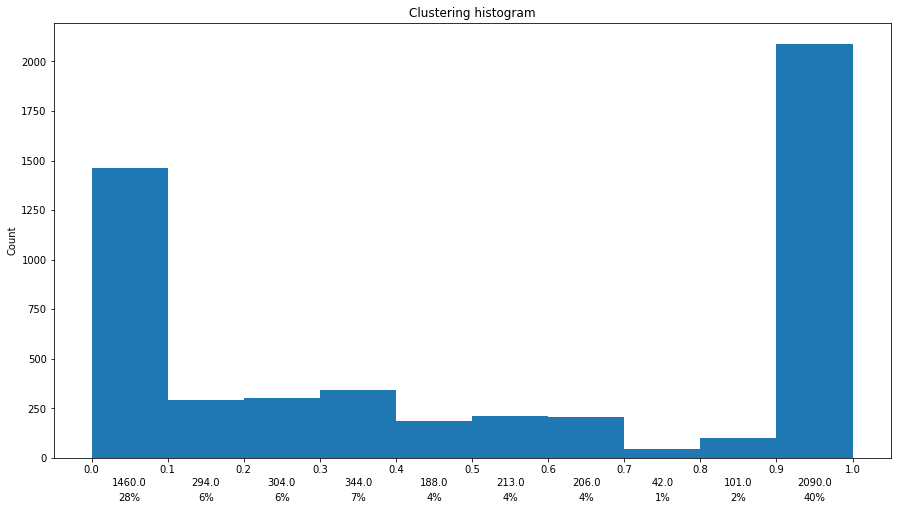

In [78]:
cluster_stat = statistics(cl, "Clustering")
cluster_stat.print_info()
cluster_stat.histogram()

## Graph level measurement

### Giant component


In [81]:
# Identify largest connected component
Gcc = sorted(nx.connected_component_subgraphs(G), key=len, reverse=True)
G0 = Gcc[0]

if(len(G)==len(G0)):
    print("Largest connected component covers the whole graph")
else:
    print("The Giant component covers the {}% of the whole graph".format(round(len(G0)/len(G)*100,2)))

The Giant component covers the 79.32% of the whole graph


### Community detection

In [84]:
from networkx.algorithms import community
from networkx.algorithms.community.quality import modularity

**Girvan-Newman algorithm**
1. The betweenness of all existing edges in the network is calculated first.
2. The edge with the highest betweenness is removed.
3. The betweenness of all edges affected by the removal is recalculated.
4. Steps 2 and 3 are repeated until no edges remain.

In [83]:
# community based on centrality measure
communities_generator = community.girvan_newman(G)
top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)

# num of communities
print(len(list(next_level_communities)))

357


In [60]:
compG0 = community.girvan_newman(G0)
next_compG0 = next(compG0)
#tuple(sorted(c) for c in next_comp)

In [61]:
len(list(next_compG0))

2

**Clauset-Newman-Moore greedy modularity maximization**

Greedy modularity maximization begins with each node in its own community and joins the pair of communities that most increases modularity until no such pair exists.

In [21]:
# community based on modularity
c = list(community.greedy_modularity_communities(G))
print("Number of communities:",len(c)) # num of communities
# each element of c contains the list of nodes belongs to each communities
#for i in range(len(c)):
    #print("community",i,"contains",len(c[i]),"nodes")

Number of communities: 418
community 0 contains 1036 nodes
community 1 contains 473 nodes
community 2 contains 416 nodes
community 3 contains 234 nodes
community 4 contains 209 nodes
community 5 contains 198 nodes
community 6 contains 187 nodes
community 7 contains 162 nodes
community 8 contains 142 nodes
community 9 contains 127 nodes
community 10 contains 100 nodes
community 11 contains 85 nodes
community 12 contains 56 nodes
community 13 contains 55 nodes
community 14 contains 47 nodes
community 15 contains 45 nodes
community 16 contains 39 nodes
community 17 contains 37 nodes
community 18 contains 34 nodes
community 19 contains 31 nodes
community 20 contains 29 nodes
community 21 contains 21 nodes
community 22 contains 20 nodes
community 23 contains 19 nodes
community 24 contains 19 nodes
community 25 contains 17 nodes
community 26 contains 16 nodes
community 27 contains 15 nodes
community 28 contains 15 nodes
community 29 contains 14 nodes
community 30 contains 14 nodes
community 

In [62]:
c1 = list(greedy_modularity_communities(G0))
print("Number of communities:",len(c1)) # num of communities
# each element of c contains the list of nodes belongs to each communities
#for i in range(len(c1)):
    #print("community",i,"contains",len(c1[i]),"nodes")

Number of communities: 66
community 0 contains 852 nodes
community 1 contains 665 nodes
community 2 contains 462 nodes
community 3 contains 384 nodes
community 4 contains 191 nodes
community 5 contains 175 nodes
community 6 contains 139 nodes
community 7 contains 89 nodes
community 8 contains 87 nodes
community 9 contains 85 nodes
community 10 contains 81 nodes
community 11 contains 77 nodes
community 12 contains 70 nodes
community 13 contains 67 nodes
community 14 contains 66 nodes
community 15 contains 54 nodes
community 16 contains 53 nodes
community 17 contains 43 nodes
community 18 contains 37 nodes
community 19 contains 33 nodes
community 20 contains 29 nodes
community 21 contains 20 nodes
community 22 contains 20 nodes
community 23 contains 16 nodes
community 24 contains 15 nodes
community 25 contains 15 nodes
community 26 contains 15 nodes
community 27 contains 14 nodes
community 28 contains 14 nodes
community 29 contains 13 nodes
community 30 contains 13 nodes
community 31 con

modularity is calculated in this way<br>
Q = $\frac{1}{2m} \sum_{ij} \left( A_{ij} - \frac{k_ik_j}{2m}\right)
            \delta(c_i,c_j)$

In [69]:
# Girvan-Newman algorithm modularity
mod_gn_whole = modularity(G,next_comp)
mod_gn_giant = modularity(G0,next_compG0)

print(mod_gn_whole,mod_gn_gian)

0.17641819590216937 0.04025705915145646


In [65]:
# Clauset-Newman-Moore High modularity because this algorithm maximize modularity
mod_cl_whole = modularity(G,c)
mod_cl_giant = modularity(G0,c1)

print(mod_cl_whole,mod_cl_giant)

0.813228021115207 0.7874799407884632


In [74]:
#Stats on the whole graph
degrees = [val for (node, val) in G.degree]
avg_degree = sum(degrees)/len(degrees)
density = nx.density(G)
diameter = 0
avg_path_lenght = 0
if(nx.is_connected(G)): # if is not connected we could not compute diameter and avg path length
    diameter = nx.diameter(G)
    avg_path_lenght = nx.average_shortest_path_length(G)
avg_clust = nx.average_clustering(G)

print("\n\n")
print("avg degree: ",avg_degree)
print("density: ",density)
print("diameter: ",diameter)
print("avg_path_lenght: ",avg_path_lenght)
print("modularity girvan-newman: ",mod_gn_whole)
print("modularity clauset-newman: ",mod_cl_whole)
print("communities girvan-newman: ",len(next_comp))
print("communities clauset-newman: ",len(c))
print("avg_clustering coeff: ",avg_clust)

avg degree:  6.458874458874459
density:  0.0015537345342493286
diameter:  17
avg_path_lenght:  6.049380016182999
modularity girvan-newman:  0.04025705915145646
modularity clauset-newman:  0.7874799407884632
communities girvan-newman:  2
communities clauset-newman:  66
avg_clustering coeff:  0.5568782161697919
avg degree:  5.530713468141931
density:  0.001055278280507905
diameter:  0
avg_path_lenght:  0
modularity girvan-newman:  0.17641819590216937
modularity clauset-newman:  0.813228021115207
communities girvan-newman:  356
communities clauset-newman:  418
avg_clustering coeff:  0.5296358110521358


In [ ]:
# Stats on the Giant Component
degrees = [val for (node, val) in G0.degree]
avg_degree = sum(degrees)/len(degrees)
density = nx.density(G0)
diameter = nx.diameter(G0)
avg_path_lenght = nx.average_shortest_path_length(G0)
avg_clust = nx.average_clustering(G0)

print("avg degree: ",avg_degree)
print("density: ",density)
print("diameter: ",diameter)
print("avg_path_lenght: ",avg_path_lenght)
print("modularity girvan-newman: ",mod_gn_giant)
print("modularity clauset-newman: ",mod_cl_giant)
print("communities girvan-newman: ",len(next_compG0))
print("communities clauset-newman: ",len(c1))
print("avg_clustering coeff: ",avg_clust)

### Display communities

In [85]:
def display_communities(graph, comms):
    llist = [] # build a list of color for each community
    for node in graph:
        for i,comm in enumerate(comms):
            if node in comm:
                llist.append(i)
                break    
    #print(llist)
    vmax = len(np.unique(llist))-1
    print(vmax)
    plt.figure(figsize=(15,10))
    nx.draw_networkx(graph,node_color=llist,cmap = 'jet',vmin = 0,vmax=vmax,font_size=0,node_size=20)

417


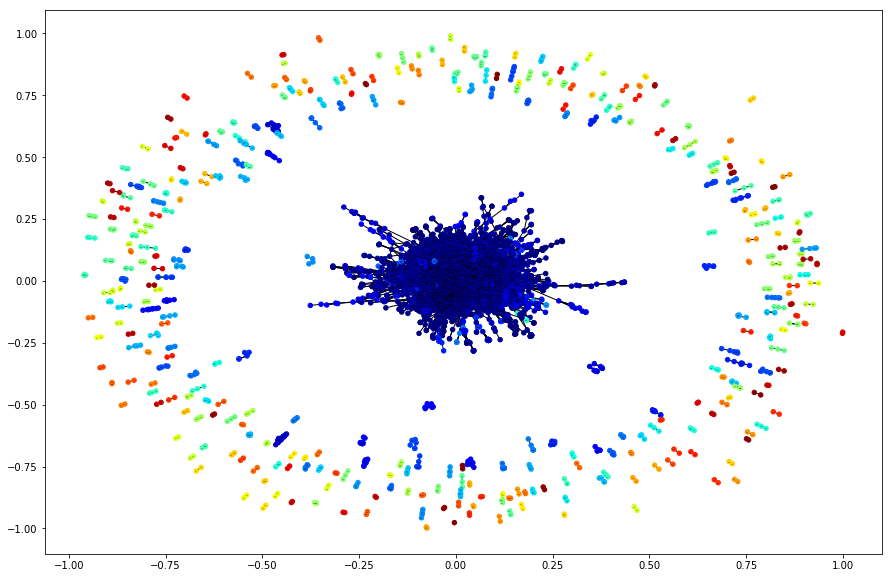

In [86]:
display_communities(G,c)

355


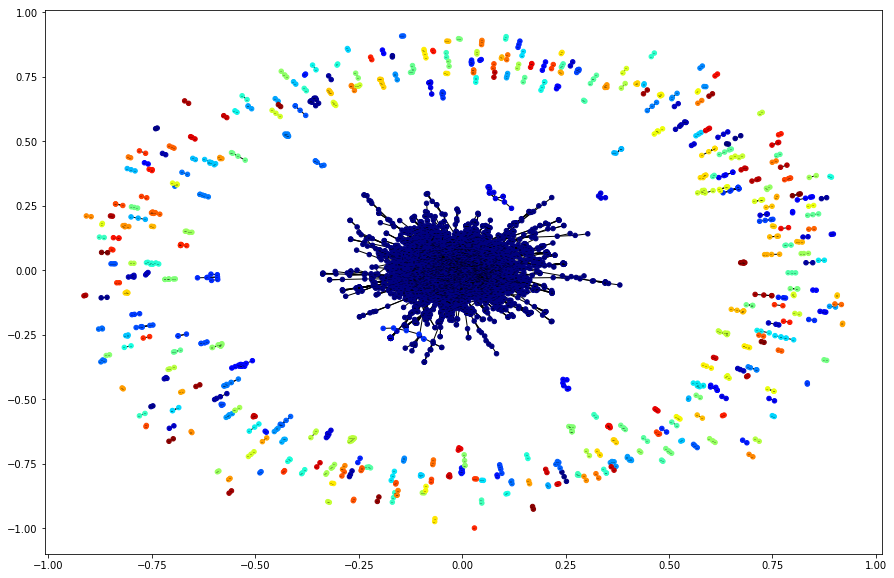

In [87]:
display_communities(G,next_comp)

65


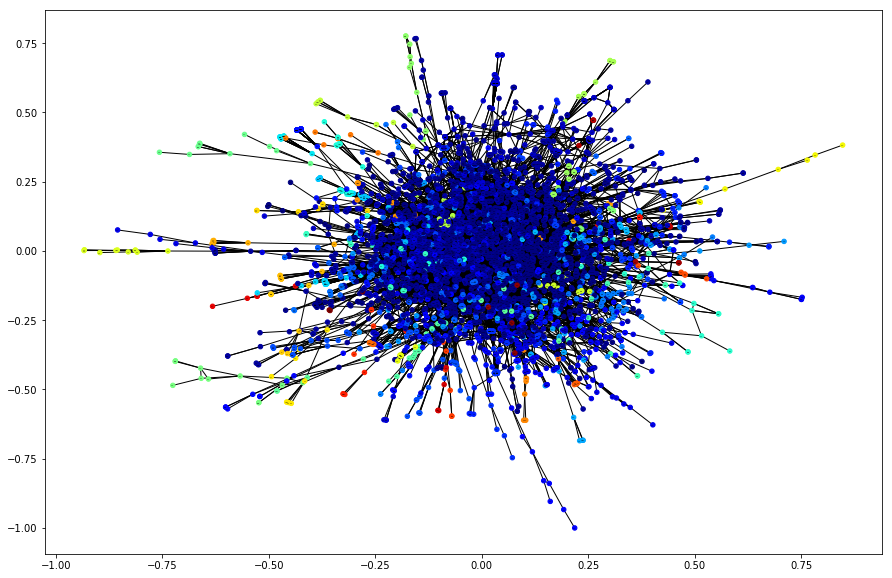

In [88]:
display_communities(G0,c1)

1


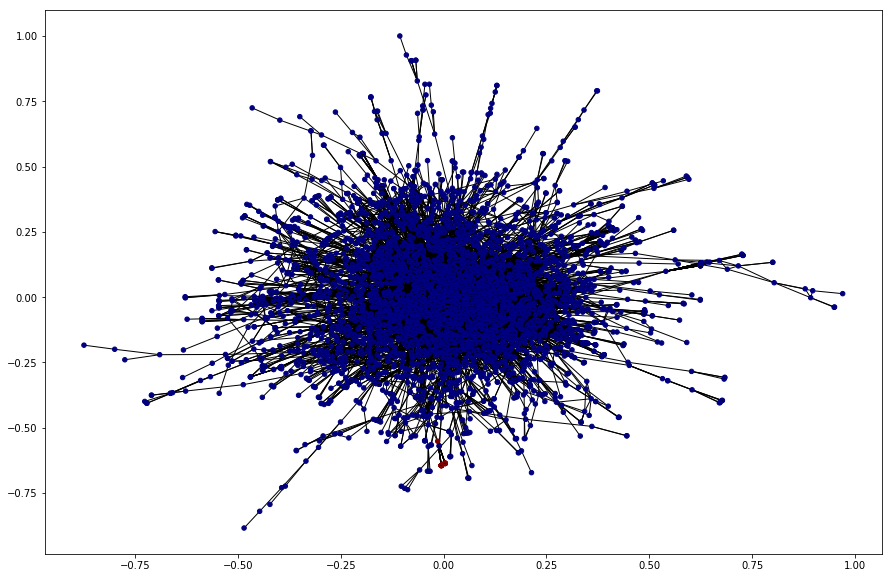

In [89]:
display_communities(G0,next_compG0)

**Does the graph have the same characteristics of a random or a power-law network?**<br>


Transitivity: 0.6298424741263426
Average degree: 5.530713468141931


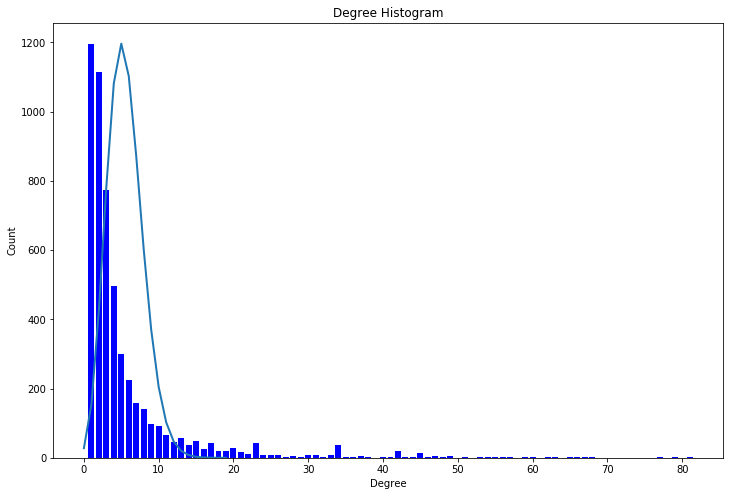

False

In [40]:
#Random

#Transitivity
#Random graph has no transitivity or clustering
print("Transitivity:",trs)

#Poisson
# Degree distribution
degree_sequence = sorted([val for (node, val) in G.degree],reverse=True)

avg_degree = sum(degree_sequence)/len(degree_sequence)
print("Average degree: {}".format(avg_degree))

degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

from scipy.stats import poisson
arr = []

rv = poisson(avg_degree)
for num in range(0,20):
    arr.append(rv.pmf(num)*7000)
    

plt.figure(figsize=(12,8))
plt.bar(deg, cnt, width=0.80, color='b')
plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.plot(arr, linewidth=2.0)
#ax.set_xticks([d + 0.4 for d in deg])
#ax.set_xticklabels(deg)
plt.show()

# CONTROLLARE avg_degree > log N if true implies that these networks should be broken into isolated clusters
avg_degree > np.log(len(G))

In [ ]:
# Power-law distribution
# As we seen in the graph below our graph behaves as a power law distribution
# Many nodes with only a few links, few hubs with large number of links

# aggiungere plot power law-distribution

**Which are the most important nodes, with respect to a given centrality measure?**<br>


In [41]:
aux = nx.degree_centrality(G)
a = [key for (key, value) in sorted(aux.items(), key= lambda item: item[1],reverse=True)[:10]]
print(a)
#fare plot e stamparli di un altro colore

['21012', '21281', '22691', '12365', '6610', '9785', '21508', '17655', '2741', '19423']


**Are the paths short with respect to the size of the network?**<br>

In [42]:
#if this ratio is near 0 it means that the short paths are much smaller than the network size; as opposite 
# if the value is near 1 it means that the short path is similar to the longest minimum path (geodesic path)
avg_path_lenght/diameter

0.3558458833048823

**Is the network dense?**<br>


In [43]:
G.number_of_edges()*2.0/float(G.number_of_nodes()*(G.number_of_nodes()-1))
#no

0.001055278280507905

In [ ]:
# DA AGGIUNGERE HITS E PAGERANK